In [57]:
using DifferentialEquations, QuadGK, Plots, Latexify, LaTeXStrings

In [58]:
abstract type CosmicEvolutionModel end

struct ΛCDM <: CosmicEvolutionModel
end

Tc(ΛCDM::ΛCDM) = 150
Tν(ΛCDM::ΛCDM) = 0.1

abstract type Particle end

struct Boson <: Particle
    name::String
    mass::Real
    spin::Int64
    dofs::Int64
end

struct Fermion <: Particle
    name::String
    mass::Real
    spin::Rational
    dofs::Int64
end

function particle_content(ΛCDM::ΛCDM, T::Real)
    @assert T >=0 "Temperature has to be a non-negative real number"
    if 0 <= T < Tc(ΛCDM)
        [Boson("Photon", 0., 1, 2), Boson("Pions", 138., 0, 3), Boson("Kaons", 494., 0, 4), Boson("η meson", 547., 0, 1), Boson("ρ mesons", 775., 1, 9),
        Boson("ω mesons", 782., 1, 3), Boson("K* mesons", 892., 1, 12),
        Fermion("Neutrinos", 0., 1//2, 6), Fermion("Electron", 0.511, 1//2, 4), Fermion("Muon", 104., 1//2, 4), Fermion("Proton", 938., 1//2, 4),
        Fermion("Neutron", 938., 1//2, 4)]
    else
        [Boson("Photon", 0., 1, 2), Boson("Gluons", 0., 1, 16), Boson("W bosons", 8.04e4, 1, 6), Boson("Z boson", 9.118e4, 1, 3), Boson("Higgs boson", 1.25e5, 0, 1),
        Fermion("Neutrinos", 0., 1//2, 6), Fermion("Electron", 0.511, 1//2, 4), Fermion("Muon", 104., 1//2, 4), Fermion("Tau", 1.78e3, 1//2, 4), Fermion("Up quark", 1.9, 1//2, 12),
        Fermion("Down quark", 4.4, 1//2, 12), Fermion("Strange quark", 95., 1//2, 12), Fermion("Charm quark", 1.275e3, 1//2, 12), Fermion("Bottom quark", 4.24e3, 1//2, 12),
        Fermion("Top quark", 1.727e5, 1//2, 12)]
    end
end

gstarᵨ(P::Particle, T::Real) = 15P.dofs/π^4*quadgk(y -> sqrt(y^2 - (P.mass/T)^2)*y^2/(exp(y) - (-1)^(2*P.spin)), P.mass/T, Inf, rtol=1e-3)[1]
gstarₚ(P::Particle, T::Real) = 15P.dofs/π^4*quadgk(y -> (y^2 - (P.mass/T)^2)^1.5/(exp(y) - (-1)^(2*P.spin)), P.mass/T, Inf, rtol=1e-3)[1]
gstarₛ(P::Particle, T::Real) = 0.75gstarᵨ(P::Particle, T::Real) + 0.25gstarₚ(P::Particle, T::Real)

gstarᵨ(ΛCDM::ΛCDM) = function(T::Real) T > Tν(ΛCDM) ? sum([gstarᵨ(particle, T) for particle in particle_content(ΛCDM, T)]) : 3.36264 end
gstarₚ(ΛCDM::ΛCDM) = function(T::Real) T > Tν(ΛCDM) ? sum([gstarₚ(particle, T) for particle in particle_content(ΛCDM, T)]) : 3.36264 end
gstarₛ(ΛCDM::ΛCDM) = function(T::Real) T > Tν(ΛCDM) ? sum([gstarₛ(particle, T) for particle in particle_content(ΛCDM, T)]) : 3.90909 end;

In [59]:
Ts = 10 .^(collect(-3:0.001:7))
gstarₛs = gstarₛ(ΛCDM()).(Ts);

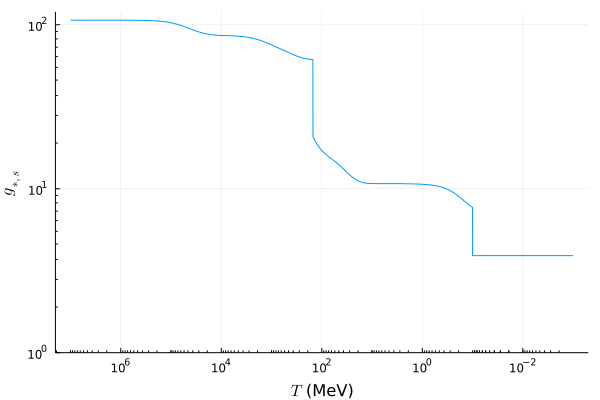

In [74]:
plot(Ts, gstarₛs, xaxis=:log10, yaxis=:log10, xflip=true, legend=false, xlabel=latexify("T")*" (MeV)", ylabel=L"g_{*, s}", xticks=[10. ^n for n in -2:2:6], ylim=(1, 120), minorticks=10)